<a href="https://colab.research.google.com/github/kevyntoro29/pneumothorax_segmentation/blob/main/dicom_to_npy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DRIVE - LIBRERIAS**

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Descomprimir el ZIP y llevarlo a una carpeta
import os
import zipfile
comprimido = zipfile.ZipFile('/content/drive/MyDrive/Dataset_medium_zip/archive.zip','r')
comprimido.extractall()
comprimido.close()

In [ ]:
from glob import glob
import pandas as pd
from tqdm import tqdm
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

In [ ]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 7.4 MB/s 


In [ ]:
import pydicom

#**PATH - FUNCTIONS**

In [ ]:
#COLAB O JUPYTER
train_path_cut_colab = '/content/siim/dicom-images-train/'
test_path_cut_colab = '/content/siim/dicom-images-test/'

# train_path_cut_jupyter = r'C:\Users\Kevyn\Downloads\Neumotórax_jupyter\Dataset_neumotórax\siim\dicom-images-train'
# test_path_cut_jupyter = r'C:\Users\Kevyn\Downloads\Neumotórax_jupyter\Dataset_neumotórax\siim\dicom-images-test'

##Colab

In [ ]:
# Input donde se encuentran los datos para llevar a cabo el proyecto:
# SIIM ACR Pneumothorax Segmentation Data. Chest X-Ray Data with Dense Segmentation
#print("Inputs: SIIM ACR Pneumothorax Segmentation Data. Chest X-Ray Data with Dense Segmentation")
#print(os.listdir('../input/siimacr-pneumothorax-segmentation-data/siim-acr-pneumothorax-segmentation-data"))
#print("")

# Se leen todos los archivos DICOM que contiene SIIM ACR Pneumothorax Segmentation Data, tanto train como test.

dicom_train_path = '/content/siim/dicom-images-train/*/*/*.dcm'
dicom_test_path = '/content/siim/dicom-images-test/*/*/*.dcm'
train_rle_csv = '/content/siim/train-rle.csv'

#dicom_train = sorted(glob("/content/siim/dicom-images-train/*/*/*.dcm"))
#dicom_test = sorted(glob("/content/siim/dicom-images-test/*/*/*.dcm"))
dicom_train = sorted(glob(dicom_train_path))
dicom_test = sorted(glob(dicom_test_path))
print("Número de muestras DICOM para el set de entrenamiento: ", len(dicom_train))
print("Número de muestras DICOM para el set de pruebas: ", len(dicom_test))

# Se resetea al valor por defecto el ancho máximo de caracteres por columna en la estructura de datos: predeterminado=50.
pd.reset_option('max_colwidth')

# Lectura del archivo .csv 'train-rle' compuesto por dos columnas:
# -ImageId:       ID de la radiografía-paciente.
# -EncodedPixels: -1 si es una radiografía sin presencia de neumotórax, o con una codificación que mapea el lugar del neumotórax.
masks_rle = pd.read_csv(train_rle_csv, delimiter=",")
# Se corrige un error tipográfico al tener el encabezado de la segunda columna un espacio al comienzo.
masks_rle.columns = ['ImageId', 'EncodedPixels']
masks_rle.head(10)

Número de muestras DICOM para el set de entrenamiento:  12089
Número de muestras DICOM para el set de pruebas:  3205


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...
5,1.2.276.0.7230010.3.1.4.8323329.11444.15178752...,-1
6,1.2.276.0.7230010.3.1.4.8323329.32219.15178751...,-1
7,1.2.276.0.7230010.3.1.4.8323329.32395.15178751...,-1
8,1.2.276.0.7230010.3.1.4.8323329.10623.15178752...,-1
9,1.2.276.0.7230010.3.1.4.8323329.12095.15178752...,-1


In [ ]:
#COLAB 

# Se crea un diccionario que recoge las entidades de interés de cada paciente de su DICOM.
def dicom_to(data, file_path, masks_rle, enco_pixels=True):
    # Se resetea al valor por defecto el ancho máximo de caracteres por columna en la estructura de datos: predeterminado=50.
    pd.reset_option('max_colwidth')

    # Se establecen los elementos de interés extraidos de la inforomación asociada por DICOM:
    # -UID: ID unívoco de la radiografía.
    # -EncodedPixels: -1 si es una radiografía sin presencia de neumotórax, o con una codificación que mapea el lugar del neumotórax.
    # -Age: edad del paciente.
    # -Sex: género del paciente.
    # -Modality: tipo de imagen tomada (CR: Computed Radiography).
    # -BodyPart: parte del cuerpo de la radiografía tomada.
    # -ViewPosition: proyección de la radiografía.
    # -Diagnosis: indicación si afección de neumotórax (True) o no (False).
    # -path: ubicación computacional de la radiografía.

    patient = {}
    
    patient["UID"] = data.SOPInstanceUID
    
    if enco_pixels:

      encoded_pixels = masks_rle[masks_rle["ImageId"] == data.SOPInstanceUID]["EncodedPixels"].values  
      patient["EncodedPixels"] = encoded_pixels
    
        
    patient["Age"] = data.PatientAge
    patient["Sex"] = data.PatientSex
    patient["Modality"] = data.Modality
    patient["BodyPart"] = data.BodyPartExamined
    patient["ViewPosition"] = data.ViewPosition
    
    if enco_pixels:
      pneumothorax = False

      for enco_pixels in encoded_pixels:
          if enco_pixels != '-1':
              pneumothorax = True
                
      patient['Diagnosis'] = pneumothorax
    
    if  enco_pixels:
        patient["path"] = train_path_cut_colab + data.StudyInstanceUID + "/" + data.SeriesInstanceUID + "/" + data.SOPInstanceUID + ".dcm"
    else:
        patient["path"] = test_path_cut_colab + data.StudyInstanceUID + "/" + data.SeriesInstanceUID + "/" + data.SOPInstanceUID + ".dcm"

    
    return patient

##Jupyter

In [ ]:
# # Input donde se encuentran los datos para llevar a cabo el proyecto:
# # SIIM ACR Pneumothorax Segmentation Data. Chest X-Ray Data with Dense Segmentation
# #print("Inputs: SIIM ACR Pneumothorax Segmentation Data. Chest X-Ray Data with Dense Segmentation")
# #print(os.listdir('../input/siimacr-pneumothorax-segmentation-data/siim-acr-pneumothorax-segmentation-data"))
# #print("")

# # Se leen todos los archivos DICOM que contiene SIIM ACR Pneumothorax Segmentation Data, tanto train como test.

# dicom_train_path = r'C:\Users\Kevyn\Downloads\Neumotórax_jupyter\Dataset_neumotórax\siim\dicom-images-train\*\*/*.dcm'
# dicom_test_path = r'C:\Users\Kevyn\Downloads\Neumotórax_jupyter\Dataset_neumotórax\siim\dicom-images-test\*\*/*.dcm'
# train_rle_csv = r'C:\Users\Kevyn\Downloads\Neumotórax_jupyter\Dataset_neumotórax\siim/train-rle.csv'

# #dicom_train = sorted(glob("/content/siim/dicom-images-train/*/*/*.dcm"))
# #dicom_test = sorted(glob("/content/siim/dicom-images-test/*/*/*.dcm"))
# dicom_train = sorted(glob(dicom_train_path))
# dicom_test = sorted(glob(dicom_test_path))
# print("Número de muestras DICOM para el set de entrenamiento: ", len(dicom_train))
# print("Número de muestras DICOM para el set de pruebas: ", len(dicom_test))

# # Se resetea al valor por defecto el ancho máximo de caracteres por columna en la estructura de datos: predeterminado=50.
# pd.reset_option('max_colwidth')

# # Lectura del archivo .csv 'train-rle' compuesto por dos columnas:
# # -ImageId:       ID de la radiografía-paciente.
# # -EncodedPixels: -1 si es una radiografía sin presencia de neumotórax, o con una codificación que mapea el lugar del neumotórax.
# masks_rle = pd.read_csv(train_rle_csv, delimiter=",")
# # Se corrige un error tipográfico al tener el encabezado de la segunda columna un espacio al comienzo.
# masks_rle.columns = ['ImageId', 'EncodedPixels']
# masks_rle.head(10)

In [ ]:
'''#Jupyter 
    
# Se crea un diccionario que recoge las entidades de interés de cada paciente de su DICOM.
def dicom_to(data, file_path, masks_rle, enco_pixels=True):
    # Se resetea al valor por defecto el ancho máximo de caracteres por columna en la estructura de datos: predeterminado=50.
    pd.reset_option('max_colwidth')

    # Se establecen los elementos de interés extraidos de la inforomación asociada por DICOM:
    # -UID: ID unívoco de la radiografía.
    # -EncodedPixels: -1 si es una radiografía sin presencia de neumotórax, o con una codificación que mapea el lugar del neumotórax.
    # -Age: edad del paciente.
    # -Sex: género del paciente.
    # -Modality: tipo de imagen tomada (CR: Computed Radiography).
    # -BodyPart: parte del cuerpo de la radiografía tomada.
    # -ViewPosition: proyección de la radiografía.
    # -Diagnosis: indicación si afección de neumotórax (True) o no (False).
    # -path: ubicación computacional de la radiografía.

    patient = {}
    
    patient["UID"] = data.SOPInstanceUID
    
    if enco_pixels:

      encoded_pixels = masks_rle[masks_rle["ImageId"] == data.SOPInstanceUID]["EncodedPixels"].values  
      patient["EncodedPixels"] = encoded_pixels
    
        
    patient["Age"] = data.PatientAge
    patient["Sex"] = data.PatientSex
    patient["Modality"] = data.Modality
    patient["BodyPart"] = data.BodyPartExamined
    patient["ViewPosition"] = data.ViewPosition
    
    if enco_pixels:
      pneumothorax = False

      for enco_pixels in encoded_pixels:
          if enco_pixels != '-1':
              pneumothorax = True
                
      patient['Diagnosis'] = pneumothorax
    
    if  enco_pixels:
        patient["path"] = train_path_cut_jupyter + "\\" + data.StudyInstanceUID + "\\" + data.SeriesInstanceUID + "/" + data.SOPInstanceUID + ".dcm"
    else:
        patient["path"] = test_path_cut_jupyter + "\\" + data.StudyInstanceUID + "\\" + data.SeriesInstanceUID + "/" + data.SOPInstanceUID + ".dcm"

    
    return patient'''

'#Jupyter \n    \n# Se crea un diccionario que recoge las entidades de interés de cada paciente de su DICOM.\ndef dicom_to(data, file_path, masks_rle, enco_pixels=True):\n    # Se resetea al valor por defecto el ancho máximo de caracteres por columna en la estructura de datos: predeterminado=50.\n    pd.reset_option(\'max_colwidth\')\n\n    # Se establecen los elementos de interés extraidos de la inforomación asociada por DICOM:\n    # -UID: ID unívoco de la radiografía.\n    # -EncodedPixels: -1 si es una radiografía sin presencia de neumotórax, o con una codificación que mapea el lugar del neumotórax.\n    # -Age: edad del paciente.\n    # -Sex: género del paciente.\n    # -Modality: tipo de imagen tomada (CR: Computed Radiography).\n    # -BodyPart: parte del cuerpo de la radiografía tomada.\n    # -ViewPosition: proyección de la radiografía.\n    # -Diagnosis: indicación si afección de neumotórax (True) o no (False).\n    # -path: ubicación computacional de la radiografía.\n\n    p

#**DATAFRAME**

In [ ]:
# Metadata de los pacientes del set de entrenamiento (entidades de interés).

# Se declara patients para construir un dataframe con los pacientes del set de entrenamiento.
patients_train = []

# Listado de todos los archivos DICOM del set de entrenamiento.
#dicom_train

# Variable dataframe que almacena las entidades de interés de cada paciente del set de entrenamiento.
df_patients_train = pd.DataFrame()

# Construcción del dataframe pacientes con los elementos de interés del set de entrenamiento.
for file_path in tqdm(dicom_train):
    data = pydicom.dcmread(file_path)
    patients_train_metadata = dicom_to(data, file_path, masks_rle)
    patients_train.append(patients_train_metadata)
df_patients_train = pd.DataFrame(patients_train)    

print("Número de imágenes DICOM verificadas (con información/relación) en el set de entrenamiento: ", df_patients_train.shape[0])
# Radiografías/pacientes con falta de información en el set de entrenamiento.

df_patients_train.head(10)

100%|██████████| 12089/12089 [00:45<00:00, 265.38it/s]


Número de imágenes DICOM verificadas (con información/relación) en el set de entrenamiento:  12089


,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,Diagnosis,path
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,[-1],38,M,CR,CHEST,PA,False,/content/siim/dicom-images-train/1.2.276.0.723...
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,[-1],10,F,CR,CHEST,AP,False,/content/siim/dicom-images-train/1.2.276.0.723...
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,[-1],50,F,CR,CHEST,AP,False,/content/siim/dicom-images-train/1.2.276.0.723...
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,[-1],68,F,CR,CHEST,AP,False,/content/siim/dicom-images-train/1.2.276.0.723...
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,[-1],65,M,CR,CHEST,AP,False,/content/siim/dicom-images-train/1.2.276.0.723...
5,1.2.276.0.7230010.3.1.4.8323329.10004.15178752...,[-1],45,F,CR,CHEST,PA,False,/content/siim/dicom-images-train/1.2.276.0.723...
6,1.2.276.0.7230010.3.1.4.8323329.10005.15178752...,[209126 1 1019 6 1015 10 1012 13 1010 14 1008 ...,53,F,CR,CHEST,PA,True,/content/siim/dicom-images-train/1.2.276.0.723...
7,1.2.276.0.7230010.3.1.4.8323329.10006.15178752...,[-1],55,M,CR,CHEST,PA,False,/content/siim/dicom-images-train/1.2.276.0.723...
8,1.2.276.0.7230010.3.1.4.8323329.10007.15178752...,[-1],26,F,CR,CHEST,PA,False,/content/siim/dicom-images-train/1.2.276.0.723...
9,1.2.276.0.7230010.3.1.4.8323329.10008.15178752...,[-1],63,M,CR,CHEST,PA,False,/content/siim/dicom-images-train/1.2.276.0.723...


In [ ]:
# Se verifica que hay una máscara (en train-rle) para todo paciente listado en el dataset train.
# 'missing' es una variable que almacena el número de radiografías/pacientes que presentan una falta de etiquetado.
missing = 0

for file_path in dicom_train:
    data = pydicom.dcmread(file_path)
    pat = {}
    pat["UID"] = data.SOPInstanceUID
    try:
        masks_rle[masks_rle["ImageId"] == pat["UID"]].values[0][1]
    except:
        missing = missing + 1
        
# Radiografías/pacientes con falta de información en el set de entrenamiento.
print("Número de imágenes DICOM del set de entrenamiento sin información de máscara RLE: ", missing)

Número de imágenes DICOM del set de entrenamiento sin información de máscara RLE:  42


In [ ]:
print("Número de muestras DICOM listadas en el fichero .csv train_rle: ", len(masks_rle))
print("Diferencia imágenes DICOM localizadas entre .csv y carpeta: ", len(masks_rle) - len(dicom_train))

Número de muestras DICOM listadas en el fichero .csv train_rle:  12954
Diferencia imágenes DICOM localizadas entre .csv y carpeta:  865


In [ ]:
# Metadata de los pacientes del set de prueba (entidades de interés).

# Se declara patients para construir un dataframe con los pacientes del set de prueba.
patients_test = []

# Listado de todos los archivos DICOM del set de prueba.
#dicom_test

# Variable dataframe que almacena las entidades de interés de cada paciente del set de prueba.
df_patients_test = pd.DataFrame()

# Construcción del dataframe pacientes con los elementos de interés del set de prueba.
for file_path in tqdm(dicom_test):
    data = pydicom.dcmread(file_path)
    patients_test_metadata = dicom_to(data, file_path, masks_rle, enco_pixels=False)
    patients_test.append(patients_test_metadata)
df_patients_test = pd.DataFrame(patients_test)    

print("Número de imágenes DICOM verificadas (con información/relación) en el set de prueba: ", df_patients_test.shape[0])
# Radiografías/pacientes con falta de información en el set de prueba.

df_patients_test.head(10)

100%|██████████| 3205/3205 [00:06<00:00, 467.57it/s]

Número de imágenes DICOM verificadas (con información/relación) en el set de prueba:  3205


,UID,Age,Sex,Modality,BodyPart,ViewPosition,path
0,ID_0011fe81e,64,F,CR,CHEST,PA,/content/siim/dicom-images-test///ID_0011fe81e...
1,ID_003206608,47,M,CR,CHEST,PA,/content/siim/dicom-images-test///ID_003206608...
2,ID_004d6fbb6,62,M,CR,CHEST,AP,/content/siim/dicom-images-test///ID_004d6fbb6...
3,ID_004d72c54,45,M,CR,CHEST,AP,/content/siim/dicom-images-test///ID_004d72c54...
4,ID_00528aa0e,38,F,CR,CHEST,AP,/content/siim/dicom-images-test///ID_00528aa0e...
5,ID_00593ac6d,63,M,CR,CHEST,PA,/content/siim/dicom-images-test///ID_00593ac6d...
6,ID_00b0e5a9f,62,F,CR,CHEST,PA,/content/siim/dicom-images-test///ID_00b0e5a9f...
7,ID_00b115bfe,24,F,CR,CHEST,PA,/content/siim/dicom-images-test///ID_00b115bfe...
8,ID_00d054471,22,F,CR,CHEST,PA,/content/siim/dicom-images-test///ID_00d054471...
9,ID_00f04769e,33,M,CR,CHEST,PA,/content/siim/dicom-images-test///ID_00f04769e...


In [ ]:
# Se eliminan del dt patients las dos radiografías que son outliers desde el punto de vista de la entidad edad.
df_pats_train = []
df_pats_train = df_patients_train.drop(df_patients_train[df_patients_train['Age']==413].index)
df_pats_train = df_pats_train.drop(df_pats_train[df_pats_train['Age']==148].index)
print("Número de muestras del dataframe patients considerando todas las muestras: ", len(df_patients_train))
print("Número de muestras del dataframe pats sin considerar los outliers de edad: ", len(df_pats_train))

Número de muestras del dataframe patients considerando todas las muestras:  12089
Número de muestras del dataframe pats sin considerar los outliers de edad:  12089


#**DECODIFICACÓN DE LA MASCARA**
-MASK2RLE FUNCIÓN PROPORCIONADA POR KAGGLE

In [ ]:
# Función original 'mask_functions.py' facilitada por el kaggle fuente:
# SIIM-ACR Pneumothorax Segmentation. Identify Pneumothorax disease in chest x-rays.
# https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/data

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [ ]:
display(df_pats_train.loc[[8891]])

,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,Diagnosis,path
8891,1.2.276.0.7230010.3.1.4.8323329.4133.151787518...,[-1],18,F,CR,CHEST,PA,False,/content/siim/dicom-images-train/1.2.276.0.723...


In [ ]:
r = df_pats_train['UID'][8891]
print(r)

#print(df_patients_train.loc[df_patients_train['UID'] == id].index.tolist())

1.2.276.0.7230010.3.1.4.8323329.4133.1517875181.272105


In [ ]:
df_pneumo_train = df_pats_train[df_pats_train["Diagnosis"] == True]
display(df_pneumo_train)

,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,Diagnosis,path
6,1.2.276.0.7230010.3.1.4.8323329.10005.15178752...,[209126 1 1019 6 1015 10 1012 13 1010 14 1008 ...,53,F,CR,CHEST,PA,True,/content/siim/dicom-images-train/1.2.276.0.723...
13,1.2.276.0.7230010.3.1.4.8323329.10011.15178752...,[49820 3 1017 11 1012 13 1009 16 1007 18 1006 ...,77,M,CR,CHEST,PA,True,/content/siim/dicom-images-train/1.2.276.0.723...
14,1.2.276.0.7230010.3.1.4.8323329.10012.15178752...,[261328 6 1015 11 1011 15 1007 18 1004 21 1002...,74,F,CR,CHEST,AP,True,/content/siim/dicom-images-train/1.2.276.0.723...
18,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,[592184 33 976 58 956 73 941 88 926 102 917 10...,57,F,CR,CHEST,PA,True,/content/siim/dicom-images-train/1.2.276.0.723...
28,1.2.276.0.7230010.3.1.4.8323329.10025.15178752...,[530522 1 1022 3 1019 6 1017 7 1016 9 1014 10 ...,30,F,CR,CHEST,PA,True,/content/siim/dicom-images-train/1.2.276.0.723...
...,...,...,...,...,...,...,...,...,...
12071,1.2.276.0.7230010.3.1.4.8323329.7037.151787520...,[643446 1 1022 5 1017 8 1015 9 1014 10 1012 12...,57,M,CR,CHEST,AP,True,/content/siim/dicom-images-train/1.2.276.0.723...
12073,1.2.276.0.7230010.3.1.4.8323329.7039.151787520...,[757984 1 4098 1 1024 2 1022 4 1021 4 1021 4 1...,52,M,CR,CHEST,PA,True,/content/siim/dicom-images-train/1.2.276.0.723...
12076,1.2.276.0.7230010.3.1.4.8323329.7041.151787520...,[400668 3 1016 10 1012 13 1008 17 1005 20 1003...,73,F,CR,CHEST,AP,True,/content/siim/dicom-images-train/1.2.276.0.723...
12080,1.2.276.0.7230010.3.1.4.8323329.7045.151787520...,[588992 2 1018 9 1012 15 1007 20 1003 23 999 2...,28,M,CR,CHEST,PA,True,/content/siim/dicom-images-train/1.2.276.0.723...


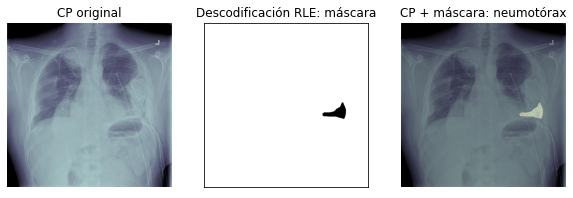

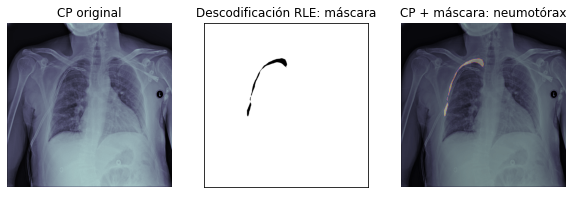

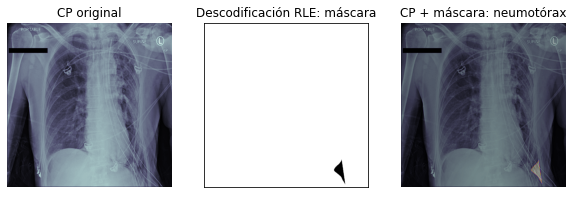

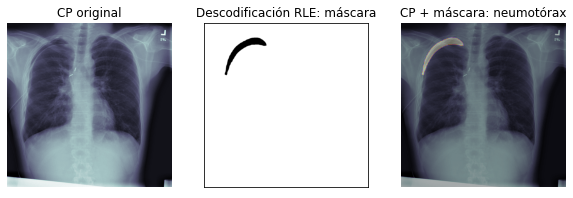

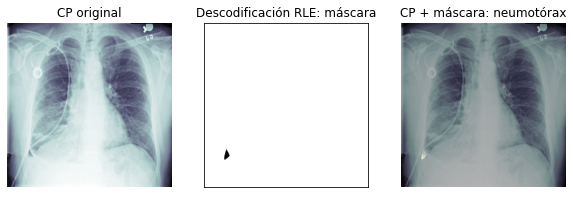

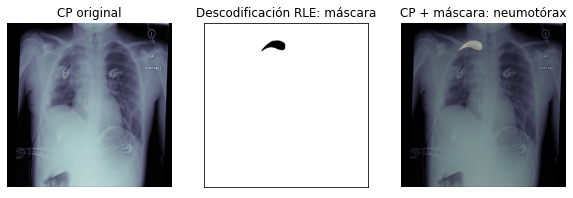

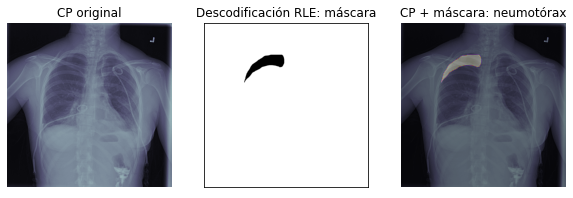

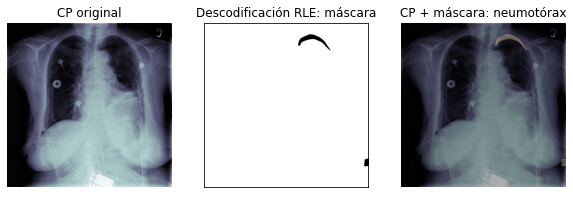

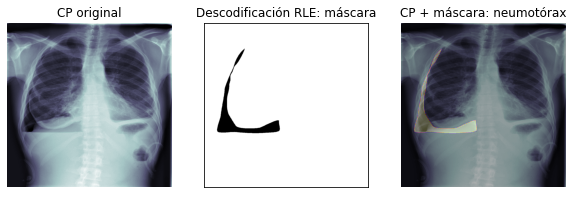

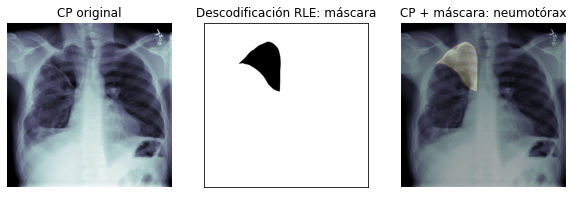

In [ ]:
# Se construye en dt con solo los pacientes con neumotórax detectado ("Diagnosis" == True]).
df_pneumo_train = df_pats_train[df_pats_train["Diagnosis"] == True]

# Arrays locales para almacenar la codificación de píxeles de la x-ray original y la máscara con la localización del neumotórax.
img_pneumo = []
mask_pneumo = []

# Se seleccionan 10 radiografías aleatorias para mostrar.
max_len = len(df_pneumo_train)
r = list(range(max_len))
random.shuffle(r)

for i in range(10):
    picked_photo = r[i]
    # Se convierte el valor rle(EncodedPixels) en una str para hacerlo oeprativo para 'rle2mask'.
    rle_tolist=list(df_pneumo_train.values[picked_photo][1])
    rle_tostr=" ".join(rle_tolist)
    
    # Se utiliza la función rle2mask facilitada para la decodificación RLE de la máscara.
    # Se llama a la transpuesta de rle2mask ya que se está usando una forma relativa de RLE, es decir, las ubicaciones de los 
    # píxeles se miden desde el final de la ejecución anterior. Lo que equibaldría manualmente a hacer:
    # Rotación de la máscara 270º en sentido horario.
    #mask = np.rot90(mask, 3)
    # Se construye el espejo de la máscara.
    #mask = np.flip(mask, axis=1)
    mask = rle2mask(rle_tostr, 1024, 1024).T
    mask_pneumo.append(mask)
    
    img = pydicom.read_file(df_pneumo_train.values[picked_photo][-1]).pixel_array
    img_pneumo.append(img)

# Representación de las 10 radiografías aleatorias y sus máscaras (ubicación del neumotórax).
x = len(img_pneumo)
for j in range(x):
    fig = plt.figure(figsize=(10, 10)) #25,25
    
    # CP original.
    a = fig.add_subplot(1, 3, 1)
    plt.imshow(img_pneumo[j], cmap=plt.cm.bone)
    a.set_title("CP original")
    plt.axis("off")

    # Descodificación RLE: máscara.
    a = fig.add_subplot(1, 3, 2)
    imgplot = plt.imshow(mask_pneumo[j], cmap='binary')
    a.set_title("Descodificación RLE: máscara")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    #CP + máscara: neumotórax
    a = fig.add_subplot(1, 3, 3)
    plt.imshow(img_pneumo[j], cmap=plt.cm.bone)
    plt.imshow(mask_pneumo[j], cmap='inferno', alpha=0.3)
    a.set_title("CP + máscara: neumotórax")
    plt.axis("off")

    plt.grid(False)

In [ ]:
print(len(r))
print(len(img_pneumo))
print(img_pneumo[0])

2669
10
[[ 43  37  33 ... 126 128 126]
 [ 40  34  30 ... 118 123 123]
 [ 38  31  27 ... 110 118 123]
 ...
 [  1   1   1 ... 126 127 130]
 [  3   3   2 ... 128 129 131]
 [  5   5   5 ... 129 129 131]]


In [ ]:
# Se listan lás máscaras de las imágenes identificadas con neumotórax.
masks = {}
for index, row in df_patients_train[df_patients_train['Diagnosis'] == True].iterrows():
    masks[row['UID']] = list(row['EncodedPixels'])

In [ ]:
# Se eliminan las radiografías/pacientes con falta de información en el set de entrenamiento: 
# radiografías/pacientes sin máscara codificada en el train-rle: 37.

# Número total de muestras del dataset a estudio (entrenamiento).
n_samp_train = len(dicom_train)

cont = 0
for i, file_path in tqdm(enumerate(dicom_train), total=n_samp_train):
    dataset = pydicom.read_file(file_path)
    
    try:
        # ID de la imagen.
        img_id = file_path.split('/')[-1][:-4]
        # Índice de la imagen en train-rle (mask_rle).
        img_id_indx = masks_rle[masks_rle['ImageId'] == img_id].index
        
        if len(img_id_indx) == 0:
            if cont == 0:
                without_rle_data = df_patients_train[df_patients_train['UID'] == img_id].index
                df_train = df_patients_train.drop(without_rle_data)
            else:
                without_rle_data = df_patients_train[df_patients_train['UID'] == img_id].index
                df_train = df_train.drop(without_rle_data)
            cont = cont + 1
        else:
            df_train = pd.DataFrame(df_patients_train)
            
    except:
        pass

100%|██████████| 12089/12089 [00:35<00:00, 339.94it/s]


In [ ]:
# División de los datos de entrenamiento en datos de entrenamiento y datos de validación (training and validation splits) con 
# muestreo estratificado (stratification).

val_size = 0.2 # División del set de entrenamiento: 20% para el conjunto de validación (80% para el conjunto de entrenamiento)

X_train, X_val, y_train, y_val = train_test_split(df_train.index, df_train['Diagnosis'].values, test_size=val_size, random_state=42)
X_train, X_val = df_train.loc[X_train]['path'].values, df_train.loc[X_val]['path'].values

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(X_val.shape)
print(y_train)

(9671,)
(2418,)
(9671,)
(2418,)
[False  True False ...  True  True False]


In [ ]:
print(X_train[0])
print(X_val[0])
print(y_train[0])
print(y_val[0])

/content/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.4178.1517875181.526811/1.2.276.0.7230010.3.1.3.8323329.4178.1517875181.526810/1.2.276.0.7230010.3.1.4.8323329.4178.1517875181.526812.dcm
/content/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.10428.1517875223.681254/1.2.276.0.7230010.3.1.3.8323329.10428.1517875223.681253/1.2.276.0.7230010.3.1.4.8323329.10428.1517875223.681255.dcm
False
False


#**DATA TRAIN NPY**

In [ ]:
#len_data = round(len(X_train)/2)
prueba = X_train#[0:10]
print(len(prueba))
'''print(len(prueba))
print(prueba[0])
print(prueba)
id = prueba.split('/')[-1][:-4]
print(id)
print(df_patients_train.loc[df_patients_train['UID'] == id].index.tolist())'''

9671


"print(len(prueba))\nprint(prueba[0])\nprint(prueba)\nid = prueba.split('/')[-1][:-4]\nprint(id)\nprint(df_patients_train.loc[df_patients_train['UID'] == id].index.tolist())"

In [ ]:
'''#PRUEBA****************************************

'Generación de datos que contengan muestras de tamaño de lote'
# Inicialización.
##X = np.empty((len(file_path_list_temp),self.img_size,self.img_size, self.channels))
##y = np.empty((len(file_path_list_temp),self.img_size,self.img_size, 1))

X = np.empty((len(prueba),256,256, 1))
y = np.empty((len(prueba),256,256, 1))

# Generación de datos.
#for idx, file_path in enumerate(file_path_list_temp):
count = 0
for idx, file_path in enumerate(prueba):   
    #pint(file_path)
    id = file_path.split('/')[-1][:-4]
    #print(id)
    rle_temp = df_patients_train.loc[df_patients_train['UID'] == id].index.tolist()
    #rint(rle_temp[0])
    #rle_temp = df_patients_train.loc[df_patients_train['UID'] == id]
    #print(len(rle_temp))
    rle = df_pats_train['EncodedPixels'][rle_temp[0]]
    #print(len(rle))
    count = count + 1
    #print(str(count)+'w'+rle)
    
    # Redimensión de las imágenes.
    image = pydicom.read_file(file_path).pixel_array
    image_resized = cv2.resize(image, (256, 256))
    #########################################################
    image_resized = np.array(image_resized, dtype=np.float64)

    image_resized = cv2.normalize(image_resized, None, 0, 255, cv2.NORM_MINMAX)
    #print(norm.min(), norm.max())
    #########################################################
    X[idx,] = np.expand_dims(image_resized, axis=2)
    #print(np.amax(X))
    # Si no hay máscara, se crea una máscara vacía.
    # Observe que se comienza con 1024p porque se necesita utilizar la función rle2mask().
    #rint(rle)
    
    if len(rle) == 0:
        mask = np.zeros((1024, 1024), dtype=np.float32)
        
    elif rle[0] == '-1':#is None:
        mask = np.zeros((1024, 1024), dtype=np.float32)
    
    else:
        if len(rle) == 1:
            mask = rle2mask(rle[0], 1024, 1024).T
        else: 
            mask = np.zeros((1024, 1024), dtype=np.float32)
            for r in rle:
                mask =  mask + rle2mask(r, 1024, 1024).T
                
    # Se almacenan las máscaras (de haber).
    mask_resized = cv2.resize(mask, (256, 256))
    y[idx,] = np.expand_dims(mask_resized, axis=2)
    y[y>0] = 255
    
X = np.uint8(X)
y = np.uint8(y)
'''

"#PRUEBA****************************************\n\n'Generación de datos que contengan muestras de tamaño de lote'\n# Inicialización.\n##X = np.empty((len(file_path_list_temp),self.img_size,self.img_size, self.channels))\n##y = np.empty((len(file_path_list_temp),self.img_size,self.img_size, 1))\n\nX = np.empty((len(prueba),256,256, 1))\ny = np.empty((len(prueba),256,256, 1))\n\n# Generación de datos.\n#for idx, file_path in enumerate(file_path_list_temp):\ncount = 0\nfor idx, file_path in enumerate(prueba):   \n    #pint(file_path)\n    id = file_path.split('/')[-1][:-4]\n    #print(id)\n    rle_temp = df_patients_train.loc[df_patients_train['UID'] == id].index.tolist()\n    #rint(rle_temp[0])\n    #rle_temp = df_patients_train.loc[df_patients_train['UID'] == id]\n    #print(len(rle_temp))\n    rle = df_pats_train['EncodedPixels'][rle_temp[0]]\n    #print(len(rle))\n    count = count + 1\n    #print(str(count)+'w'+rle)\n    \n    # Redimensión de las imágenes.\n    image = pydicom.read

In [ ]:
#PRUEBA***********2222222222222222222*****************

'Generación de datos que contengan muestras de tamaño de lote'
# Inicialización.
##X = np.empty((len(file_path_list_temp),self.img_size,self.img_size, self.channels))
##y = np.empty((len(file_path_list_temp),self.img_size,self.img_size, 1))

# X = np.empty((len(prueba),256,256, 1))
# y = np.empty((len(prueba),256,256, 1))

img_npy = []
mask_npy = []

# Generación de datos.
#for idx, file_path in enumerate(file_path_list_temp):
count = 0
#for idx, file_path in tqdm(enumerate(prueba)):   
for file_path in tqdm(prueba):   

    id = file_path.split('/')[-1][:-4]
    #print(id)
    rle_temp = df_patients_train.loc[df_patients_train['UID'] == id].index.tolist()
    #rint(rle_temp[0])
    #rle_temp = df_patients_train.loc[df_patients_train['UID'] == id]
    #print(len(rle_temp))
    rle = df_pats_train['EncodedPixels'][rle_temp[0]]
    #print(len(rle))
    count = count + 1
    #print(str(count)+'w'+rle)
    
    # Redimensión de las imágenes.
    image = pydicom.read_file(file_path).pixel_array
    image_resized = cv2.resize(image, (256, 256))
    #########################################################
    image_resized = np.array(image_resized, dtype=np.float64)

    image_resized = cv2.normalize(image_resized, None, 0, 255, cv2.NORM_MINMAX)
    img_npy.append(image_resized)
    #print(norm.min(), norm.max())
    #########################################################
    ##X[idx,] = np.expand_dims(image_resized, axis=2)
    #print(np.amax(X))
    # Si no hay máscara, se crea una máscara vacía.
    # Observe que se comienza con 1024p porque se necesita utilizar la función rle2mask().
    #rint(rle)
    
    if len(rle) == 0:
        mask = np.zeros((1024, 1024), dtype=np.float32)
        
    elif rle[0] == '-1':#is None:
        mask = np.zeros((1024, 1024), dtype=np.float32)
    
    else:
        if len(rle) == 1:
            mask = rle2mask(rle[0], 1024, 1024).T
        else: 
            mask = np.zeros((1024, 1024), dtype=np.float32)
            for r in rle:
                mask =  mask + rle2mask(r, 1024, 1024).T
                
    # Se almacenan las máscaras (de haber).
    mask_resized = cv2.resize(mask, (256, 256))
    mask_npy.append(mask_resized)
    #y[idx,] = np.expand_dims(mask_resized, axis=2)
    #y[y>0] = 255
    
img_npy = np.uint8(img_npy)
mask_npy = np.uint8(mask_npy)


100%|██████████| 9671/9671 [03:48<00:00, 42.40it/s]


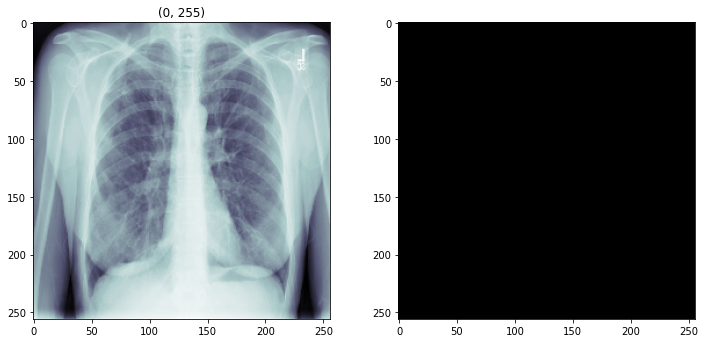

In [ ]:
d = 0
rango_X = np.amin(img_npy),np.amax(img_npy)
rango_y = np.amin(mask_npy),np.amax(mask_npy)
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
#ax1.imshow(X[d][:,:,0], cmap=plt.cm.bone)
ax1.imshow(img_npy[d], cmap=plt.cm.bone)
ax1.set_title(rango_X)
ax2 = fig.add_subplot(2,2,2)
#ax2.imshow(y[d][:,:,0], cmap = plt.cm.bone)# cmap='binary')
ax2.imshow(mask_npy[d], cmap = plt.cm.bone)# cmap='binary')

In [ ]:
X_train_npy = np.array(img_npy)
np.save("X_train.npy",X_train_npy)

In [ ]:
y_train_npy = np.array(mask_npy)
np.save("y_train.npy",y_train_npy)

#**DATA VAL NPY**

In [ ]:
#len_data = round(len(X_train)/2)
prueba = X_val#[0:10]
print(len(prueba))
'''print(len(prueba))
print(prueba[0])
print(prueba)
id = prueba.split('/')[-1][:-4]
print(id)
print(df_patients_train.loc[df_patients_train['UID'] == id].index.tolist())'''

2418


"print(len(prueba))\nprint(prueba[0])\nprint(prueba)\nid = prueba.split('/')[-1][:-4]\nprint(id)\nprint(df_patients_train.loc[df_patients_train['UID'] == id].index.tolist())"

In [ ]:
'''#PRUEBA****************************************

'Generación de datos que contengan muestras de tamaño de lote'
# Inicialización.
##X = np.empty((len(file_path_list_temp),self.img_size,self.img_size, self.channels))
##y = np.empty((len(file_path_list_temp),self.img_size,self.img_size, 1))

X = np.empty((len(prueba),256,256, 1))
y = np.empty((len(prueba),256,256, 1))

# Generación de datos.
#for idx, file_path in enumerate(file_path_list_temp):
count = 0
for idx, file_path in enumerate(prueba):   
    #pint(file_path)
    id = file_path.split('/')[-1][:-4]
    #print(id)
    rle_temp = df_patients_train.loc[df_patients_train['UID'] == id].index.tolist()
    #rint(rle_temp[0])
    #rle_temp = df_patients_train.loc[df_patients_train['UID'] == id]
    #print(len(rle_temp))
    rle = df_pats_train['EncodedPixels'][rle_temp[0]]
    #print(len(rle))
    count = count + 1
    #print(str(count)+'w'+rle)
    
    # Redimensión de las imágenes.
    image = pydicom.read_file(file_path).pixel_array
    image_resized = cv2.resize(image, (256, 256))
    #########################################################
    image_resized = np.array(image_resized, dtype=np.float64)

    image_resized = cv2.normalize(image_resized, None, 0, 255, cv2.NORM_MINMAX)
    #print(norm.min(), norm.max())
    #########################################################
    X[idx,] = np.expand_dims(image_resized, axis=2)
    #print(np.amax(X))
    # Si no hay máscara, se crea una máscara vacía.
    # Observe que se comienza con 1024p porque se necesita utilizar la función rle2mask().
    #rint(rle)
    
    if len(rle) == 0:
        mask = np.zeros((1024, 1024), dtype=np.float32)
        
    elif rle[0] == '-1':#is None:
        mask = np.zeros((1024, 1024), dtype=np.float32)
    
    else:
        if len(rle) == 1:
            mask = rle2mask(rle[0], 1024, 1024).T
        else: 
            mask = np.zeros((1024, 1024), dtype=np.float32)
            for r in rle:
                mask =  mask + rle2mask(r, 1024, 1024).T
                
    # Se almacenan las máscaras (de haber).
    mask_resized = cv2.resize(mask, (256, 256))
    y[idx,] = np.expand_dims(mask_resized, axis=2)
    y[y>0] = 255
    
X = np.uint8(X)
y = np.uint8(y)
'''

"#PRUEBA****************************************\n\n'Generación de datos que contengan muestras de tamaño de lote'\n# Inicialización.\n##X = np.empty((len(file_path_list_temp),self.img_size,self.img_size, self.channels))\n##y = np.empty((len(file_path_list_temp),self.img_size,self.img_size, 1))\n\nX = np.empty((len(prueba),256,256, 1))\ny = np.empty((len(prueba),256,256, 1))\n\n# Generación de datos.\n#for idx, file_path in enumerate(file_path_list_temp):\ncount = 0\nfor idx, file_path in enumerate(prueba):   \n    #pint(file_path)\n    id = file_path.split('/')[-1][:-4]\n    #print(id)\n    rle_temp = df_patients_train.loc[df_patients_train['UID'] == id].index.tolist()\n    #rint(rle_temp[0])\n    #rle_temp = df_patients_train.loc[df_patients_train['UID'] == id]\n    #print(len(rle_temp))\n    rle = df_pats_train['EncodedPixels'][rle_temp[0]]\n    #print(len(rle))\n    count = count + 1\n    #print(str(count)+'w'+rle)\n    \n    # Redimensión de las imágenes.\n    image = pydicom.read

In [ ]:
#PRUEBA***********2222222222222222222*****************

'Generación de datos que contengan muestras de tamaño de lote'
# Inicialización.
##X = np.empty((len(file_path_list_temp),self.img_size,self.img_size, self.channels))
##y = np.empty((len(file_path_list_temp),self.img_size,self.img_size, 1))

# X = np.empty((len(prueba),256,256, 1))
# y = np.empty((len(prueba),256,256, 1))

img_npy = []
mask_npy = []

# Generación de datos.
#for idx, file_path in enumerate(file_path_list_temp):
count = 0
#for idx, file_path in tqdm(enumerate(prueba)):   
for file_path in tqdm(prueba):   

    id = file_path.split('/')[-1][:-4]
    #print(id)
    rle_temp = df_patients_train.loc[df_patients_train['UID'] == id].index.tolist()
    #rint(rle_temp[0])
    #rle_temp = df_patients_train.loc[df_patients_train['UID'] == id]
    #print(len(rle_temp))
    rle = df_pats_train['EncodedPixels'][rle_temp[0]]
    #print(len(rle))
    count = count + 1
    #print(str(count)+'w'+rle)
    
    # Redimensión de las imágenes.
    image = pydicom.read_file(file_path).pixel_array
    image_resized = cv2.resize(image, (256, 256))
    #########################################################
    image_resized = np.array(image_resized, dtype=np.float64)

    image_resized = cv2.normalize(image_resized, None, 0, 255, cv2.NORM_MINMAX)
    img_npy.append(image_resized)
    #print(norm.min(), norm.max())
    #########################################################
    ##X[idx,] = np.expand_dims(image_resized, axis=2)
    #print(np.amax(X))
    # Si no hay máscara, se crea una máscara vacía.
    # Observe que se comienza con 1024p porque se necesita utilizar la función rle2mask().
    #rint(rle)
    
    if len(rle) == 0:
        mask = np.zeros((1024, 1024), dtype=np.float32)
        
    elif rle[0] == '-1':#is None:
        mask = np.zeros((1024, 1024), dtype=np.float32)
    
    else:
        if len(rle) == 1:
            mask = rle2mask(rle[0], 1024, 1024).T
        else: 
            mask = np.zeros((1024, 1024), dtype=np.float32)
            for r in rle:
                mask =  mask + rle2mask(r, 1024, 1024).T
                
    # Se almacenan las máscaras (de haber).
    mask_resized = cv2.resize(mask, (256, 256))
    mask_npy.append(mask_resized)
    #y[idx,] = np.expand_dims(mask_resized, axis=2)
    #y[y>0] = 255
    
img_npy = np.uint8(img_npy)
mask_npy = np.uint8(mask_npy)


100%|██████████| 2418/2418 [01:14<00:00, 32.47it/s]


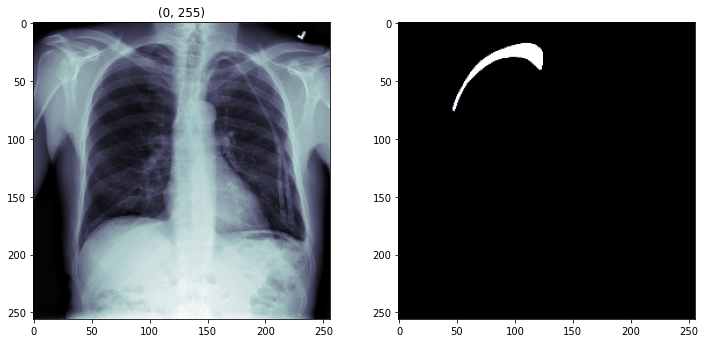

In [ ]:
d = 2
rango_X = np.amin(img_npy),np.amax(img_npy)
rango_y = np.amin(mask_npy),np.amax(mask_npy)
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
#ax1.imshow(X[d][:,:,0], cmap=plt.cm.bone)
ax1.imshow(img_npy[d], cmap=plt.cm.bone)
ax1.set_title(rango_X)
ax2 = fig.add_subplot(2,2,2)
#ax2.imshow(y[d][:,:,0], cmap = plt.cm.bone)# cmap='binary')
ax2.imshow(mask_npy[d], cmap = plt.cm.bone)# cmap='binary')

In [ ]:
X_val_npy = np.array(img_npy)
np.save("X_val.npy",X_val_npy)


In [ ]:
y_val_npy = np.array(mask_npy)
np.save("y_val.npy",y_val_npy)